In [1]:
%matplotlib inline
from SALib.sample import saltelli
from SALib.analyze import sobol
from mesa.batchrunner import batch_run
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import clear_output

from model import SugarscapeG1mt

### Sensitivity Analysis - Problem

In [2]:
problem = {
    "num_vars": 12,
    "names": [
        "initial_population",
        "endowment_min",
        "endowment_max",
        "vision_min",
        "vision_max",
        "metabolism_min",
        "metabolism_max",
        "wealth_tax_system",
        "flat_rate",
        "wealth_tax_period",
        "income_tax_system",
        "income_tax_flat_rate"
    ],
    "bounds": [
        [50,   500],    # initial_population
        [10,    50],    # endowment_min
        [50,   100],    # endowment_max
        [1,     10],    # vision_min
        [1,     10],    # vision_max
        [1,     10],    # metabolism_min
        [1,     10],    # metabolism_max
        [0,     3],     # wealth_tax_regime (see wealth_tax_map)
        [0.0,   0.10],  # flat_rate
        [1,     50],    # wealth_tax_period
        [0,     3],     # income_tax_system (see income_tax_map)
        [0.0,   0.20],  # income_tax_flat_rate
    ]
}

model_reporters = {
    "Gini": lambda m:m.datacollector.get_model_vars_dataframe()['Gini'].iloc[-1],
}

wealth_tax_map = {
    0: "none",  # No wealth tax
    1: "proportional",  # Proportional
    2: "progressive",  # Progressive tax
    3: "degressive"   # Regressive tax
}

income_tax_map = {
    0: "none",  # No income tax
    1: "proportional",  # Proportional income tax
    2: "progressive",  # Progressive income tax
    3: "degressive"   # Regressive income tax
}

integer_vars = {
    "initial_population",
    "endowment_min",
    "endowment_max",
    "vision_min",
    "vision_max",
    "metabolism_min",
    "metabolism_max",
    "wealth_tax_period",
}

In [3]:

# --- 2) OFAT (one-factor-at-a-time) sweep ---
replicates   = 2
max_steps    = 10
distinct_OAT = 2

test_vars = ["initial_population", "flat_rate"]

OAT_results = {}
# for i, var in enumerate(problem["names"]):
for var in test_vars:
    i = problem["names"].index(var)
    low, high = problem["bounds"][i]

    # 5a) Categorical parameters: use the map values
    if var == "wealth_tax_regime":
        samples = list(wealth_tax_map.values())
    elif var == "income_tax_system":
        samples = list(income_tax_map.values())

    # 5b) Integer parameters: linspace with dtype=int
    elif var in integer_vars:
        samples = np.linspace(low, high, distinct_OAT, dtype=int)

    # 5c) All other continuous parameters
    else:
        samples = np.linspace(low, high, distinct_OAT)

    # 6) Run the batch
    results = batch_run(
        SugarscapeG1mt,
        parameters={var: samples},
        iterations=replicates,
        max_steps=max_steps,
        data_collection_period=1,
        display_progress=True
    )

    # 7) Collect into a DataFrame
    df = pd.DataFrame(results)
    # print(df.columns.tolist())    # ← inspect the real column names
    # print(df.head())       
    # keep only the columns we care about:
    #   - the varied var
    #   - the run number
    #   - the final reporter ("Gini")
    OAT_results[var] = df[[var, "RunId", "Gini"]]
for var, df in OAT_results.items():
    print(f"\n=== {var} ===")
    print(df)

  0%|          | 0/4 [00:00<?, ?it/s]

/Users/bartkoedijk/Bestanden/ABM/ABM/model.py:25: RuntimeWarning: Mean of empty slice.
  return np.exp(np.log(list_of_prices).mean())
/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Index(['#Traders', 'Trade Volume', 'Price', 'Treasury Sugar', 'Treasury Spice',
       'Treasury Total', 'redistributed cummulative', 'trading', 'Gini',
       'Lorenz'],
      dtype='object')
Index(['#Traders', 'Trade Volume', 'Price', 'Treasury Sugar', 'Treasury Spice',
       'Treasury Total', 'redistributed cummulative', 'trading', 'Gini',
       'Lorenz'],
      dtype='object')
Index(['#Traders', 'Trade Volume', 'Price', 'Treasury Sugar', 'Treasury Spice',
       'Treasury Total', 'redistributed cummulative', 'trading', 'Gini',
       'Lorenz'],
      dtype='object')
Index(['#Traders', 'Trade Volume', 'Price', 'Treasury Sugar', 'Treasury Spice',
       'Treasury Total', 'redistributed cummulative', 'trading', 'Gini',
       'Lorenz'],
      dtype='object')


  0%|          | 0/4 [00:00<?, ?it/s]

/Users/bartkoedijk/Bestanden/ABM/ABM/model.py:25: RuntimeWarning: Mean of empty slice.
  return np.exp(np.log(list_of_prices).mean())
/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Index(['#Traders', 'Trade Volume', 'Price', 'Treasury Sugar', 'Treasury Spice',
       'Treasury Total', 'redistributed cummulative', 'trading', 'Gini',
       'Lorenz'],
      dtype='object')
Index(['#Traders', 'Trade Volume', 'Price', 'Treasury Sugar', 'Treasury Spice',
       'Treasury Total', 'redistributed cummulative', 'trading', 'Gini',
       'Lorenz'],
      dtype='object')
Index(['#Traders', 'Trade Volume', 'Price', 'Treasury Sugar', 'Treasury Spice',
       'Treasury Total', 'redistributed cummulative', 'trading', 'Gini',
       'Lorenz'],
      dtype='object')
Index(['#Traders', 'Trade Volume', 'Price', 'Treasury Sugar', 'Treasury Spice',
       'Treasury Total', 'redistributed cummulative', 'trading', 'Gini',
       'Lorenz'],
      dtype='object')

=== initial_population ===
       initial_population  RunId      Gini
0                      50      0  0.086006
1                      50      0  0.086006
2                      50      0  0.086006
3                      50   

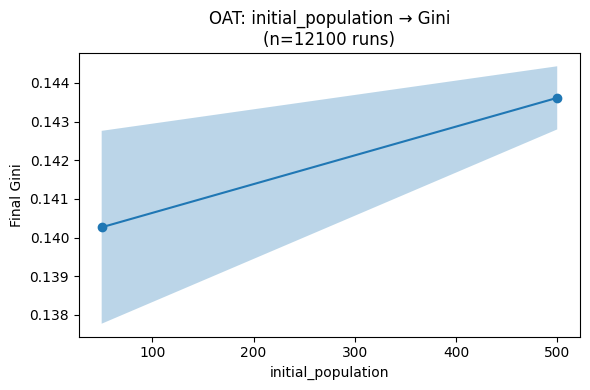

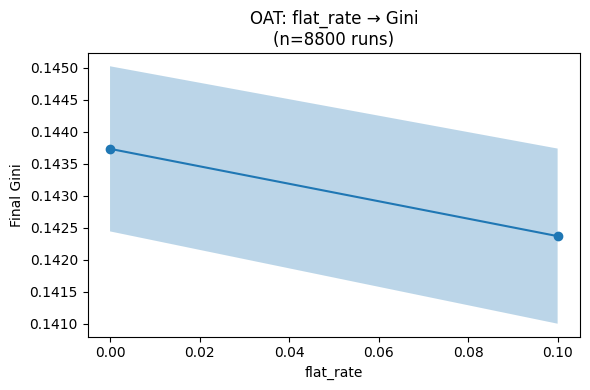

In [6]:
for var in ["initial_population", "flat_rate"]:
    df = OAT_results[var]   # this DF has columns [var, "Gini"]

    # Group by the parameter value
    grp = df.groupby(var)["Gini"]
    x    = grp.mean().index.astype(float)
    y    = grp.mean().values
    sem  = grp.sem().values
    ci   = 1.96 * sem    # 95% interval

    plt.figure(figsize=(6,4))
    plt.plot(x, y, marker="o")
    plt.fill_between(x, y - ci, y + ci, alpha=0.3)
    plt.xlabel(var)
    plt.ylabel("Final Gini")
    plt.title(f"OAT: {var} → Gini\n(n={len(df)} runs)")
    plt.tight_layout()
    plt.show()

### Global Sensitivity Analysis - Sobol

In [9]:
# --- 3) Sobol GSA ---
replicates    = 2
max_steps     = 100
distinct_SA   = 2

param_values = saltelli.sample(problem, distinct_SA, calc_second_order=False)
total_runs = replicates * len(param_values)
print(f"Total runs for Sobol GSA: {total_runs}")

# 6) Run the model over the Sobol design
records = []
count = 0

for run_id in range(replicates):
    for vals in param_values:
        # Decode the raw sample vector into a param dict
        vals = list(vals)
        params = {}
        for name, val in zip(problem["names"], vals):
            if name in integer_vars:
                params[name] = int(round(val))
            elif name == "wealth_tax_system":
                params[name] = wealth_tax_map[int(round(val))]
            elif name == "income_tax_system":
                params[name] = income_tax_map[int(round(val))]
            else:
                params[name] = float(val)

        for low_key, high_key in [
            ("endowment_min",   "endowment_max"),
            ("vision_min",      "vision_max"),
            ("metabolism_min",  "metabolism_max"),
        ]:
            lo = params[low_key]
            hi = params[high_key]
            lo, hi = int(min(lo, hi)), int(max(lo, hi))
            params[low_key], params[high_key] = lo, hi
            
        # Run one iteration
        out = batch_run(
            SugarscapeG1mt,
            parameters=params,
            iterations=1,
            max_steps=max_steps,
            data_collection_period=1,
            display_progress=False
        )[0]

        # Record the final Gini
        records.append({
            **params,
            "RunId": run_id,
            "Gini": out["Gini"]
        })

        # Progress bar
        count += 1
        clear_output(wait=True)
        print(f"Completed {count}/{total_runs} runs ({count/total_runs*100:.1f}%)")


Completed 56/56 runs (100.0%)


/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


ValueError: keyword ha is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

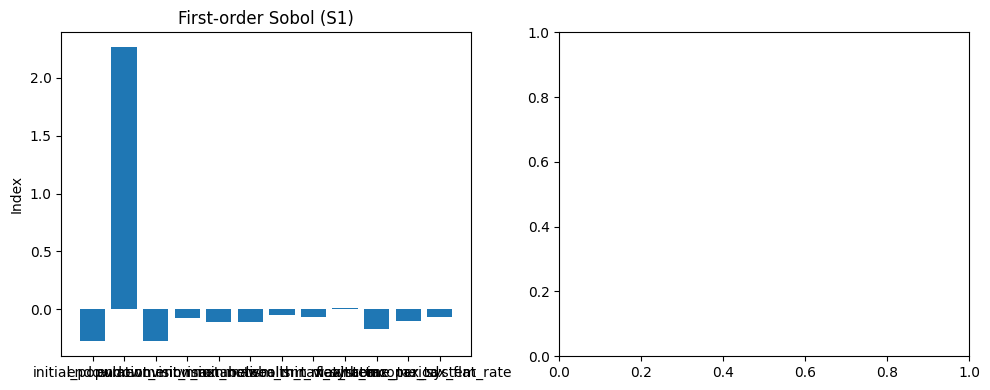

In [ ]:
# 7) Build the DataFrame and extract Y
df = pd.DataFrame(records)
Y  = df["Gini"].values

# 8) Perform Sobol analysis
Si = sobol.analyze(
    problem,
    Y,
    calc_second_order=False,
    print_to_console=False
)

fig, axes = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

# First‐order
axes[0].bar(problem["names"], Si["S1"])
axes[0].set_title("First‐order Sobol (S1)")
axes[0].set_ylabel("Index")
# rotate labels
axes[0].tick_params(axis="x", labelrotation=45)
# right‐align tick labels
for lbl in axes[0].get_xticklabels():
    lbl.set_ha("right")

# Total‐order
axes[1].bar(problem["names"], Si["ST"])
axes[1].set_title("Total‐order Sobol (ST)")
axes[1].tick_params(axis="x", labelrotation=45)
for lbl in axes[1].get_xticklabels():
    lbl.set_ha("right")

plt.show()